# DOC

数据清洗

* 缺失值填充
* 类别型变量处理
    - 将用数值表示的类别型变量转换为类别型变量
    - 将类别型变量转换为有序类别型变量
    - 将类别型变量转换为哑变量
* Box-Cox变换: 将分布为偏态分布的变量转换为近似正态分布

特征工程



回归模型

* Lasso
* XGBoost
* LightGBM

# 1. Libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 100)
pd.set_option("display.float_format", lambda x: "{:.3f}".format(x))

from scipy import stats
from scipy.stats import norm, skew
from scipy.stats.stats import pearsonr

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
color = sns.color_palette()
sns.set_style("darkgrid")

# import warnings
# def ignore_warn(*args, **kwargs):
#     pass
# warning.warn = ignore_warn


from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
import xgboost
from sklearn.metrics import mean_squared_error, mean_squared_log_error

# 2. Configuration

In [2]:
# train and test dataset path
train_path = "./data/train.csv"
test_path = "./data/test.csv"

# 3. Train and Test Dataset

### 3.1 读入数据及数据初步探索

In [3]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [4]:
train.head(6)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.000,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.000,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000


In [5]:
test.head(6)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,CBlock,TA,TA,No,Rec,468.000,LwQ,144.000,270.000,882.000,GasA,TA,Y,SBrkr,896,0,0,896,0.000,0.000,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.000,Unf,1.000,730.000,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.000,TA,TA,CBlock,TA,TA,No,ALQ,923.000,Unf,0.000,406.000,1329.000,GasA,TA,Y,SBrkr,1329,0,0,1329,0.000,0.000,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.000,Unf,1.000,312.000,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,PConc,Gd,TA,No,GLQ,791.000,Unf,0.000,137.000,928.000,GasA,Gd,Y,SBrkr,928,701,0,1629,0.000,0.000,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.000,Fin,2.000,482.000,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.000,TA,TA,PConc,TA,TA,No,GLQ,602.000,Unf,0.000,324.000,926.000,GasA,Ex,Y,SBrkr,926,678,0,1604,0.000,0.000,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.000,Fin,2.000,470.000,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.000,Gd,TA,PConc,Gd,TA,No,ALQ,263.000,Unf,0.000,1017.000,1280.000,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.000,0.000,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.000,RFn,2.000,506.000,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
5,1466,60,RL,75.000,10000,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1993,1994,Gable,CompShg,HdBoard,HdBoard,None,0.000,TA,TA,PConc,Gd,TA,No,Unf,0.000,Unf,0.000,763.000,763.000,GasA,Gd,Y,SBrkr,763,892,0,1655,0.000,0.000,2,1,3,1,TA,7,Typ,1,TA,Attchd,1993.000,Fin,2.000,440.000,TA,TA,Y,157,84,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal


In [6]:
print("训练数据形状:", train.shape)
print("测试数据形状:", test.shape)

训练数据形状: (1460, 81)
测试数据形状: (1459, 80)


### 3.2 数据特殊变量(Id, SalePrice)处理

#### (1) `Id` 变量的处理

保存 train 和 test 的 `Id` 变量:

In [7]:
train_Id = train["Id"]
test_Id = test["Id"]

删除 train 和 test 的 `Id` 变量:

In [8]:
# train.drop("Id", axis = 1, inplace = True)
# test.drop("Id", axis = 1, inplace = True)

处理后的 train 和 test 的形状:

In [9]:
# print("训练数据形状:", train.shape)
# print("测试数据形状:", test.shape)

#### (2) 训练数据中目标变量 `SalePrice` 的处理

保存 train 的 `SalePrice` 变量:

In [10]:
train_target = train["SalePrice"]

删除 train 的 `SalePrice` 变量:

In [11]:
# train.drop("SalePrice", axis = 0, inplace = True)

# 4. 数据探索性分析及清洗

* 4.1 目标变量分析及处理
* 4.2 异常值检测及处理
* 4.3 缺失值检测及处理
    - 对含缺失值的数值型变量用各自特征的均值进行填充
* 4.4 数值变量分析及处理
    - 对偏态分布的数值特征进行 $log(x+1)$ 转换;
        - `np.log1p(feature)`
* 4.5 类别型变量分析及处理
    - 有序类别型变量
    - 无序类别型变量
        - 重编码, 生成哑变量(dummary variable)
            - `sklearn.preprocessing.OneHotEncoding().transformation().fit()`

## 4.1 目标变量分析及处理

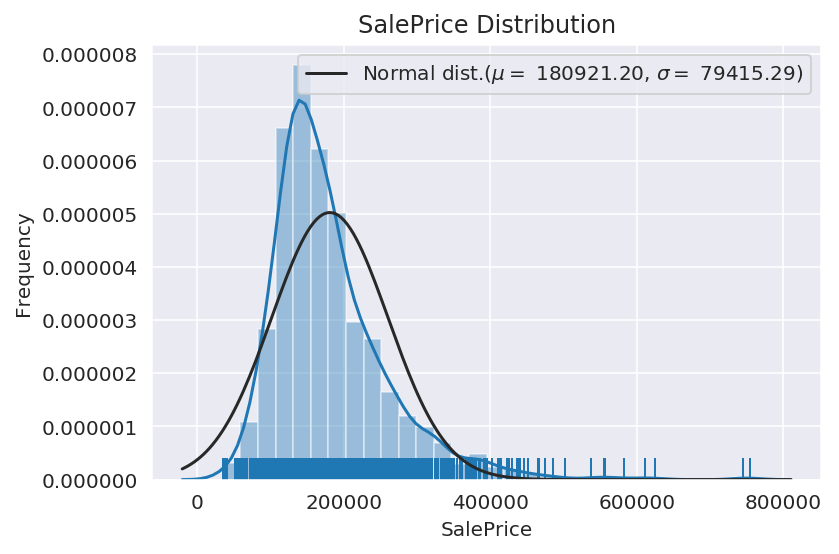

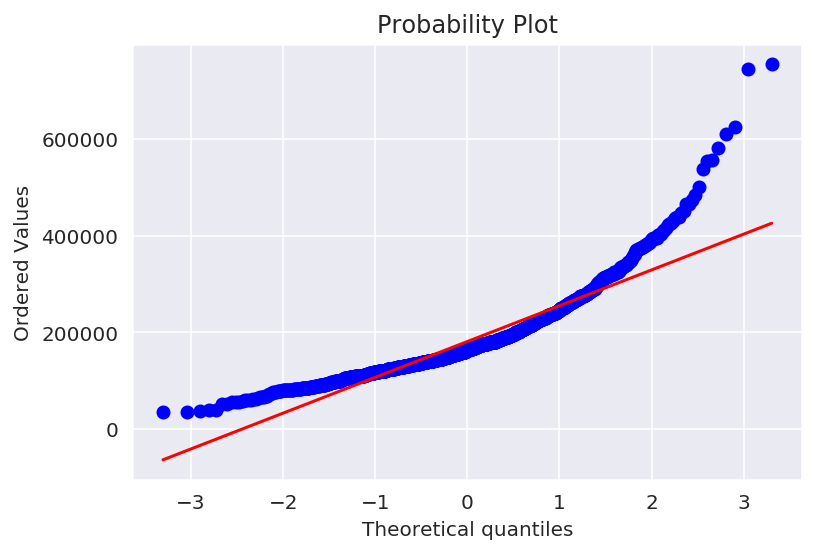

In [12]:
# sns.distplot(train_target, bins = 30, hist = True, kde = False, rug = False);
# sns.distplot(train_target, bins = 30, hist = False, kde = True, rug = False);
# sns.distplot(train_target, bins = 30, hist = False, kde = False, rug = True);
# sns.distplot(train_target, hist = True, kde = True, rug = True);
# sns.distplot(train_target, bins = 30, hist = True, kde = True, rug = True, fit = norm);
sns.distplot(train_target, bins = 30, hist = True, kde = True, rug = True, fit = norm)
(mu, sigma) = norm.fit(train_target)
plt.legend(["Normal dist.($\mu=$ {:.2f}, $\sigma=$ {:.2f})".format(mu, sigma)], 
           loc = "best")
plt.ylabel("Frequency")
plt.title("SalePrice Distribution");

# QQ-plot
fig = plt.figure()
res = stats.probplot(train_target, plot = plt)
plt.show()

* 目标变量 `SalePrice` 是右偏的
* 对 `SalePrice` 进行对数转换,使得 `SalePrice` 变得接近正态分布

In [13]:
train_target_log1p = np.log1p(train_target)

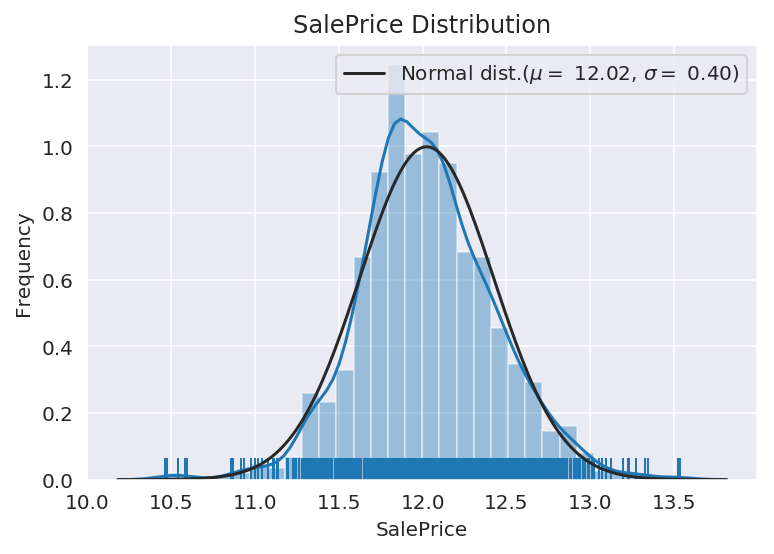

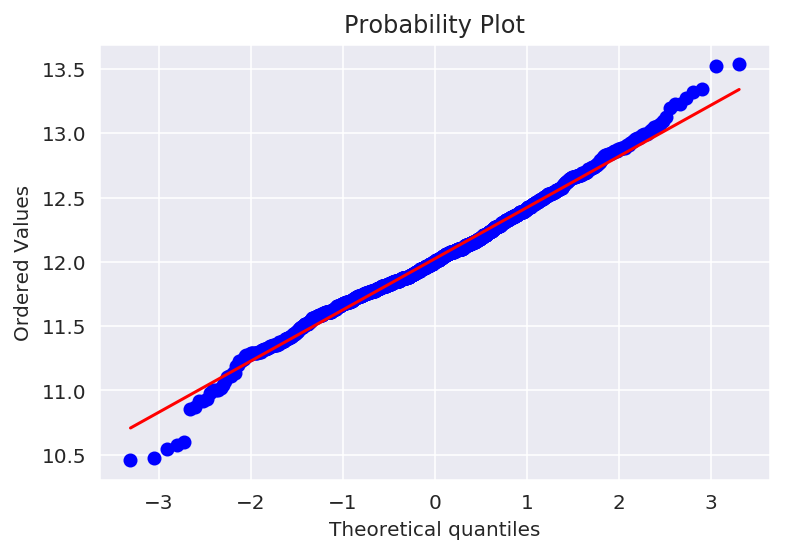

In [14]:
sns.distplot(train_target_log1p, bins = 30, hist = True, kde = True, rug = True, fit = norm)
(mu, sigma) = norm.fit(train_target_log1p)
plt.legend(["Normal dist.($\mu=$ {:.2f}, $\sigma=$ {:.2f})".format(mu, sigma)], 
           loc = "best")
plt.ylabel("Frequency")
plt.title("SalePrice Distribution");

# QQ-plot
fig = plt.figure()
res = stats.probplot(train_target_log1p, plot = plt)
plt.show()

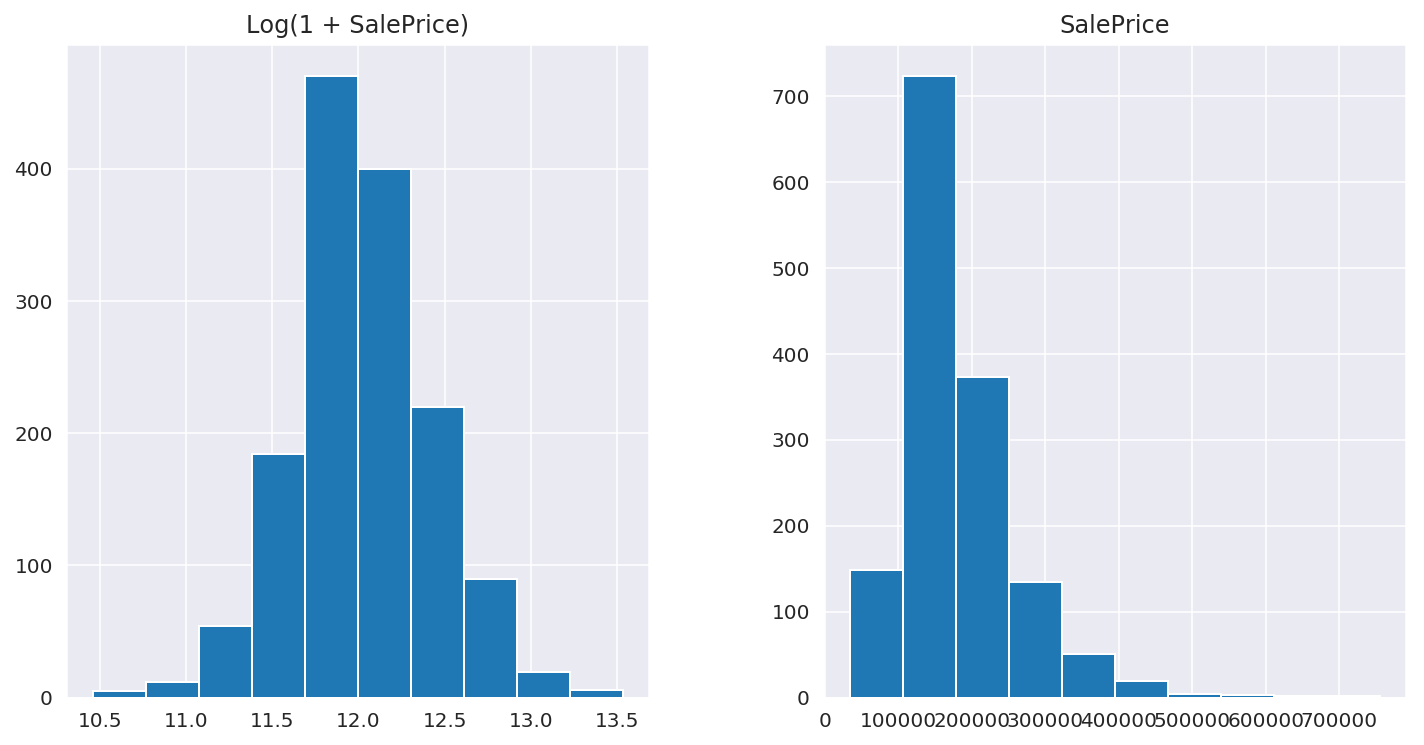

In [15]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
SalePrice_df = pd.DataFrame({
    "SalePrice": train_target,
    "Log(1 + SalePrice)": train_target_log1p
})
SalePrice_df.hist();

In [16]:
train["SalePrice"] = np.log1p(train["SalePrice"])

## 4.2 异常值检测及处理

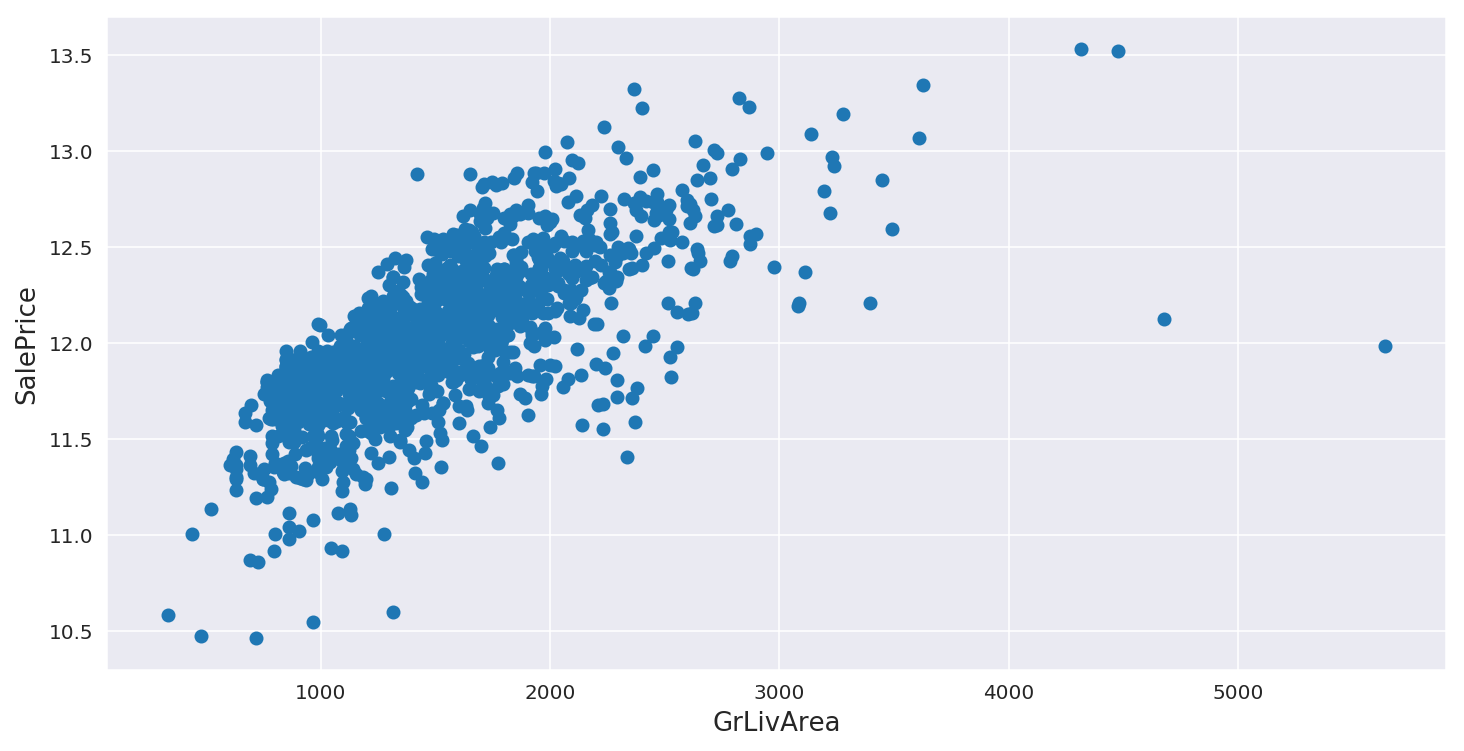

In [17]:
fig, ax = plt.subplots()
ax.scatter(x = train["GrLivArea"], y = train["SalePrice"])
plt.ylabel("SalePrice", fontsize = 13)
plt.xlabel("GrLivArea", fontsize = 13)
plt.show()

* 存在两个面积(GrLivArea > 4000)特别大,而价格(SalePrice < 300000)却不是很高的房子
* 认为这两个观测值属于异常值，直接将他们删除

In [18]:
outliers = train[(train["GrLivArea"] > 4000) & (train["SalePrice"] < 200000)].index
train.loc[outliers]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,524,60,RL,130.000,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.000,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260,Unf,0,878,3138,GasA,Ex,Y,SBrkr,3138,1538,0,4676,1,0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007.000,Fin,3,884,TA,TA,Y,208,406,0,0,0,0,NaN,NaN,NaN,0,10,2007,New,Partial,12.127
691,692,60,RL,104.000,21535,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.000,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455,Unf,0,989,2444,GasA,Ex,Y,SBrkr,2444,1872,0,4316,0,1,3,1,4,1,Ex,10,Typ,2,Ex,Attchd,1994.000,Fin,3,832,TA,TA,Y,382,50,0,0,0,0,NaN,NaN,NaN,0,1,2007,WD,Normal,13.534
1182,1183,60,RL,160.000,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.000,Gd,TA,PConc,Ex,TA,Av,GLQ,2096,Unf,0,300,2396,GasA,Ex,Y,SBrkr,2411,2065,0,4476,1,0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996.000,Fin,3,813,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,13.521
1298,1299,60,RL,313.000,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.000,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.000,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,11.983


In [19]:
train = train.drop(outliers, axis = 0)

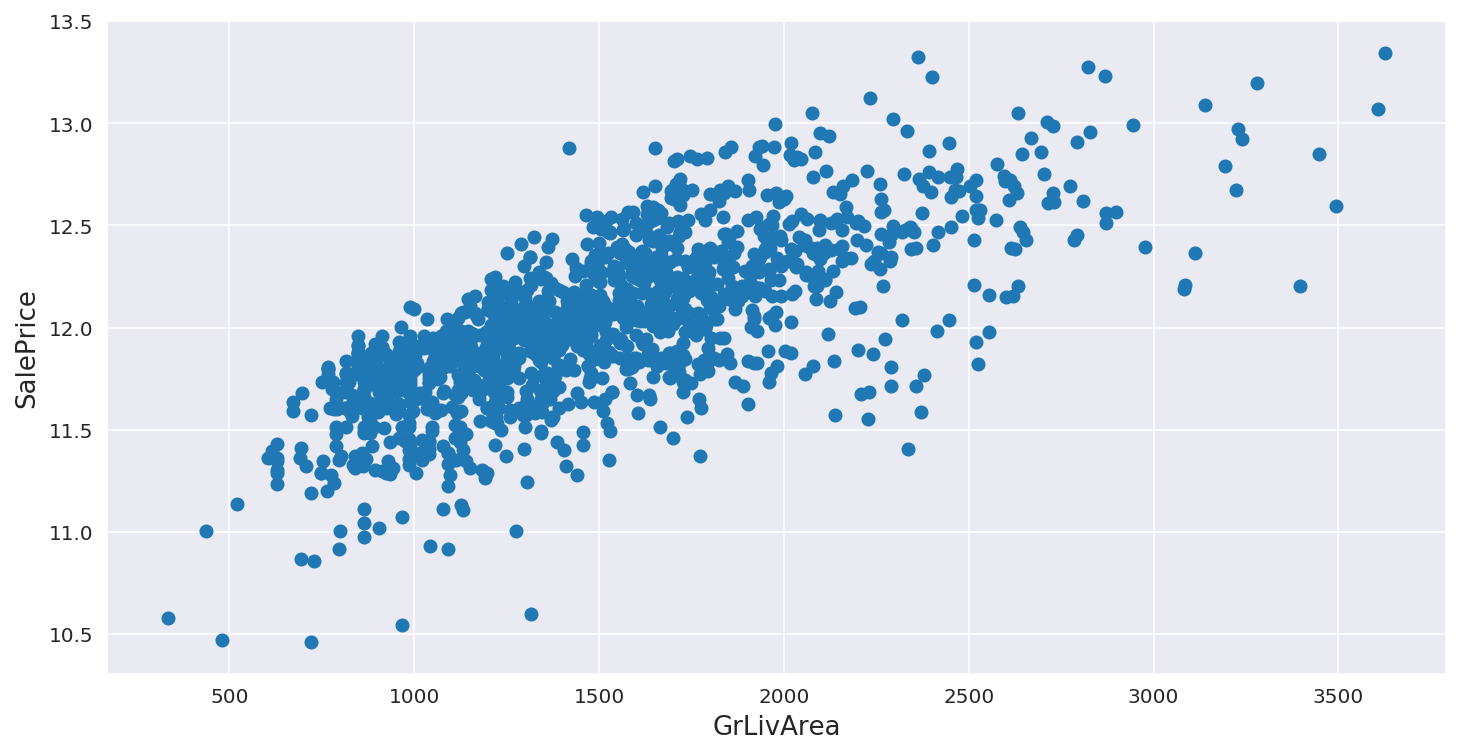

In [20]:
fig, ax = plt.subplots()
ax.scatter(x = train["GrLivArea"], y = train['SalePrice'])
plt.ylabel("SalePrice", fontsize = 13)
plt.xlabel("GrLivArea", fontsize = 13)
plt.show()

## 4.4 数值变量分析及处理

### 4.4.1 将 train 和 test 合并起来,方便数据探索性分析和清洗:

In [21]:
frames = [train.loc[:, "MSSubClass":"SaleCondition"], test.loc[:, "MSSubClass":"SaleCondition"]]
data = pd.concat(frames, axis = 0)
data.shape

(2915, 79)

In [22]:
data.head(6)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706.000,Unf,0.000,150.000,856.000,GasA,Ex,Y,SBrkr,856,854,0,1710,1.000,0.000,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.000,RFn,2.000,548.000,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.000,Unf,0.000,284.000,1262.000,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.000,1.000,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000,RFn,2.000,460.000,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.000,Unf,0.000,434.000,920.000,GasA,Ex,Y,SBrkr,920,866,0,1786,1.000,0.000,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000,RFn,2.000,608.000,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216.000,Unf,0.000,540.000,756.000,GasA,Gd,Y,SBrkr,961,756,0,1717,1.000,0.000,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000,Unf,3.000,642.000,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655.000,Unf,0.000,490.000,1145.000,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.000,0.000,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000,RFn,3.000,836.000,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
5,50,RL,85.000,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,Wood,Gd,TA,No,GLQ,732.000,Unf,0.000,64.000,796.000,GasA,Ex,Y,SBrkr,796,566,0,1362,1.000,0.000,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.000,Unf,2.000,480.000,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal


### 4.4.2 将数值变量和类别性变量分开

In [23]:
# 特征的数据类型
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    print(data.dtypes)

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1       float64
BsmtFinType2      object
BsmtFinSF2       float64
BsmtUnfSF        float64
TotalBsmtSF      float64
Heating           object
HeatingQC         object


In [24]:
numeric_features = data.dtypes[data.dtypes != 'object'].index
numeric_features

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [25]:
categorical_features = data.dtypes[data.dtypes == 'object'].index
categorical_features

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

### 4.4.3 数值变量分布偏度分析

数值变量偏度及偏度超过0.75的特征:

In [26]:
features_skew = data[numeric_features] \
    .apply(lambda x: skew(x.dropna())) \
    .sort_values(axis = 0, ascending = False)
features_skew

MiscVal         21.932
PoolArea        18.702
LotArea         13.124
LowQualFinSF    12.080
3SsnPorch       11.368
KitchenAbvGr     4.299
BsmtFinSF2       4.142
EnclosedPorch    4.001
ScreenPorch      3.944
BsmtHalfBath     3.941
MasVnrArea       2.588
OpenPorchSF      2.529
WoodDeckSF       1.848
MSSubClass       1.375
1stFlrSF         1.253
LotFrontage      1.113
GrLivArea        0.978
BsmtFinSF1       0.974
BsmtUnfSF        0.920
2ndFlrSF         0.843
TotRmsAbvGrd     0.750
Fireplaces       0.726
HalfBath         0.699
TotalBsmtSF      0.667
BsmtFullBath     0.622
OverallCond      0.569
BedroomAbvGr     0.328
GarageArea       0.220
MoSold           0.198
OverallQual      0.182
FullBath         0.160
YrSold           0.131
GarageCars      -0.218
GarageYrBlt     -0.380
YearRemodAdd    -0.449
YearBuilt       -0.598
dtype: float64

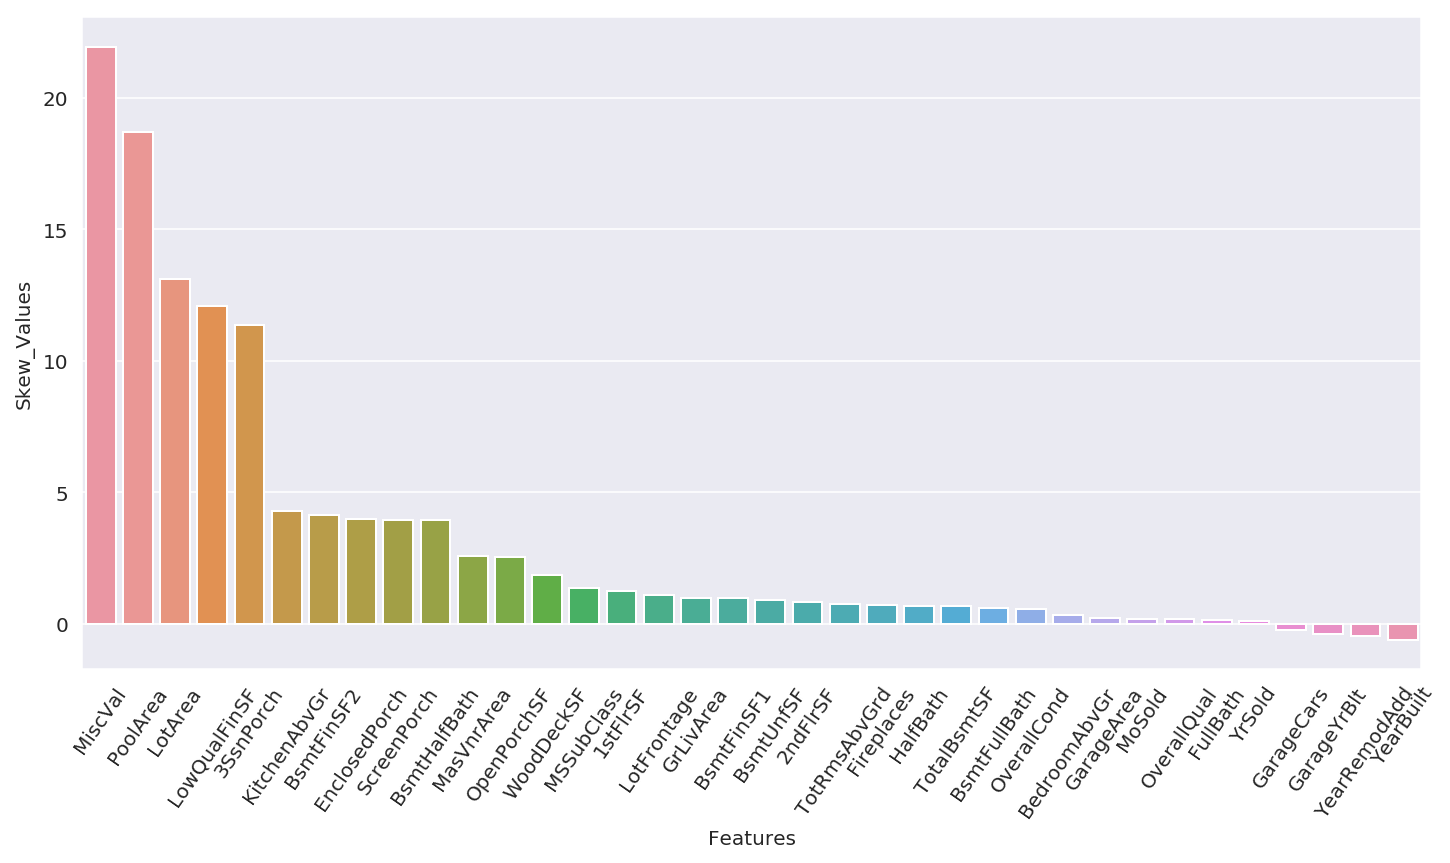

In [27]:
features_skew_df = pd.DataFrame({
    "Features": features_skew.index,
    "Skew_Values": features_skew.values
})
sns.barplot(x = features_skew_df["Features"], 
            y = features_skew_df["Skew_Values"], 
            data = features_skew_df)
plt.xticks(rotation = 55);

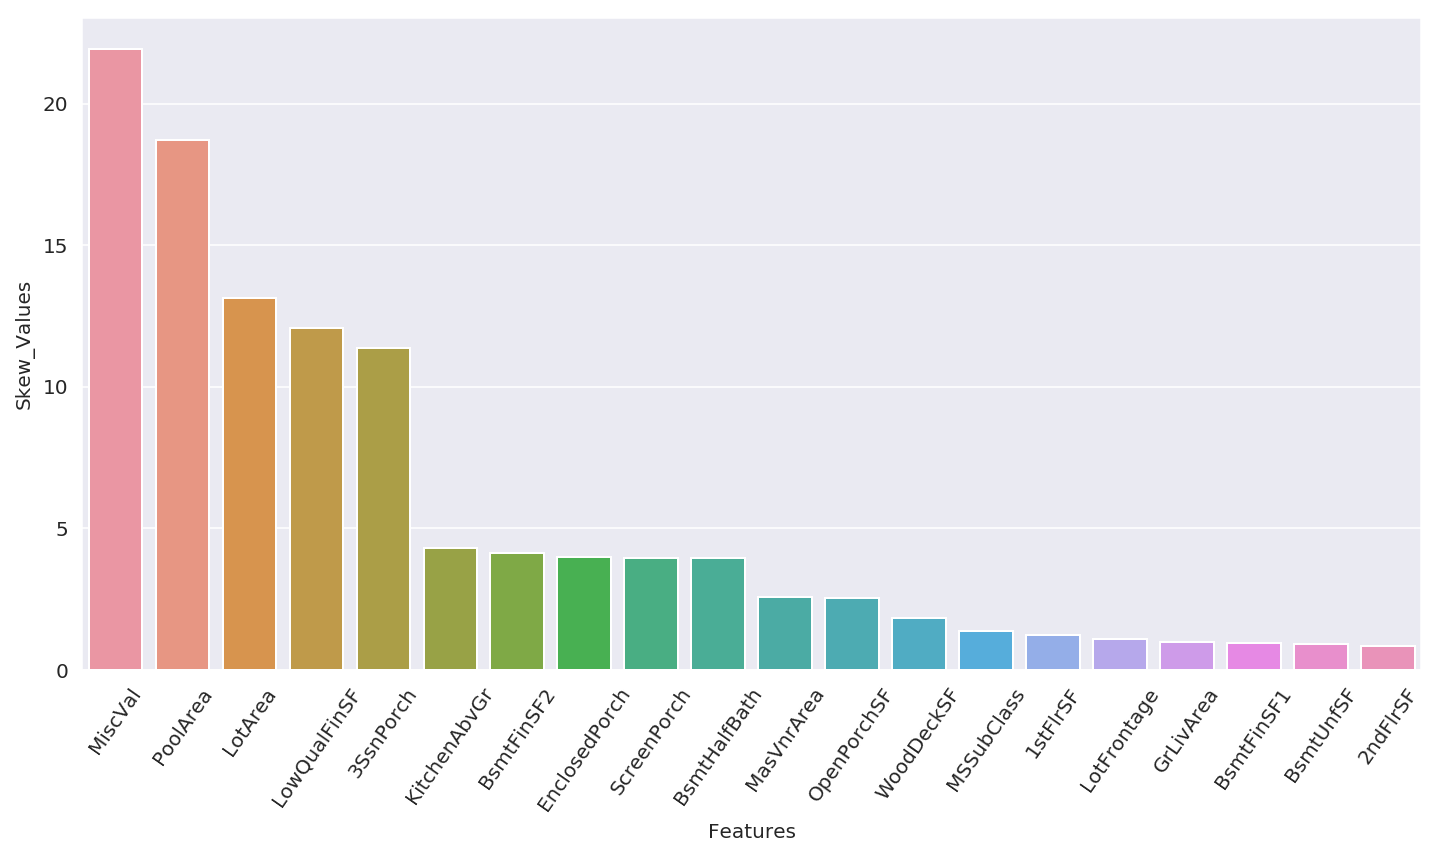

In [28]:
sns.barplot(x = features_skew_df[np.abs(features_skew_df.Skew_Values) > 0.75]["Features"], 
            y = features_skew_df[np.abs(features_skew_df.Skew_Values) > 0.75]["Skew_Values"], 
            data = features_skew_df[np.abs(features_skew_df.Skew_Values) > 0.75])
plt.xticks(rotation = 55);

将偏度超过0.75的特征进行 $log(1 + x)$ 转换:

In [29]:
skewed_features = features_skew[np.abs(features_skew) > 0.75].index
data[skewed_features] = np.log1p(data[skewed_features])

features_skew = data[numeric_features] \
    .apply(lambda x: skew(x.dropna())) \
    .sort_values(axis = 0, ascending = False)
features_skew

PoolArea        16.332
3SsnPorch        8.819
LowQualFinSF     8.552
MiscVal          5.210
BsmtHalfBath     3.783
KitchenAbvGr     3.517
ScreenPorch      2.943
BsmtFinSF2       2.459
EnclosedPorch    1.959
TotRmsAbvGrd     0.750
Fireplaces       0.726
HalfBath         0.699
TotalBsmtSF      0.667
BsmtFullBath     0.622
OverallCond      0.569
MasVnrArea       0.525
BedroomAbvGr     0.328
2ndFlrSF         0.308
MSSubClass       0.247
GarageArea       0.220
MoSold           0.198
OverallQual      0.182
WoodDeckSF       0.161
FullBath         0.160
YrSold           0.131
1stFlrSF         0.025
OpenPorchSF     -0.040
GrLivArea       -0.045
GarageCars      -0.218
GarageYrBlt     -0.380
YearRemodAdd    -0.449
LotArea         -0.533
YearBuilt       -0.598
BsmtFinSF1      -0.617
LotFrontage     -0.907
BsmtUnfSF       -2.157
dtype: float64